## **Market Network Analysis - Market Similarities**

**Background:**

This notebook is the first part of the Social Network Analysis that we will perform on the Luxury Industry. We will create a network based on companies market similarities: Leather Goods, Jewelry and Watch, etc. This market based approach will allow us to see which Luxury Companies operate on the same market segments and will guide us for the NLP Analysis.

**Dataset:**

We will work with a dataset of Luxury Brands Market Segmentation provided by Bloomberg Terminal. More specially, we used the Bloomberg Intelligence BI LUXGG to get the data. Access to the Terminal was possible thanks to Copenhagen Business School Data Lab.

**Resources:**

*   Pandas documentation: https://pandas.pydata.org/docs/#
*   DataCamp course: https://app.datacamp.com/learn/courses/analyzing-social-media-data-in-python
*   Data Science for Business Applications course - Copenhagen Business School
*   Holoviews documentation: http://holoviews.org/user_guide/Network_Graphs.html



## **Import Libraries and Data**

In [ ]:
# import essential libraries

%%capture
import networkx as nx  #for the manipulation of networks 
import numpy as np  #for useful maths functions
import pandas as pd  #for the manipulation of dataframes 
import seaborn as sns  #for visualization
import matplotlib.pyplot as plt  #for visualization
from scipy import sparse  #for high-level functions
import community.community_louvain as community_louvain  #community detection inside networks
from sklearn.metrics.pairwise import cosine_distances  #cosine distance between two variables
sns.set(color_codes=True, rc={'figure.figsize':(10,8)})  #set seaborn
sns.set()

In [ ]:
#Note: There can be problems of versions when importing holoviews and bokeh, do not rerun the cell below!

%%capture

!pip install -qq holoviews
!pip install -qq -U bokeh==2.4.1

#Solution in case of a problem: 

#1) install holoviews 1.14 and bokeh 2.3.2
#2) install holoviews and bokeh 2.4.1
#3) install holoviews 1.14.4 and install bokeh 2.4.1

In [ ]:
# install datashader and scikit-image 

%%capture
!pip install -qq datashader
!pip install -qq scikit-image

In [ ]:
# import the network visualization libraries and backend

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))
from holoviews.operation.datashader import datashade, bundle_graph

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load market segmentation data
df = pd.read_excel('/content/drive/MyDrive/Final Project/Network Analysis/Bloomberg Intelligence - BI LUXGG.xlsx', sheet_name = "Licenses - Brands")

df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,Brand,Ticker,Field ID,Field Mnemonic,Data State,Brand Owner,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Spirits
1,NaN,NaN,NaN,NaN,Static,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brunello Cucinelli,NaN,NaN,NaN,Static,Brunello Cucinelli,x,NaN,NaN,NaN,x,x,NaN,NaN,NaN,NaN
3,Burberry,NaN,NaN,NaN,Static,Burberry,x,x,x,x,x,x,x,NaN,x,NaN
4,Christopher Kane,NaN,NaN,NaN,Static,Christopher Kane,x,x,NaN,NaN,x,x,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Hogan,NaN,NaN,NaN,Static,Tod's,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN
201,Fay,NaN,NaN,NaN,Static,Tod's,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,Roger Vivier,NaN,NaN,NaN,Static,Tod's,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,Tumi,NaN,NaN,NaN,Static,Samsonite,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,NaN


## **Data pre-processing**

In [ ]:
%%capture
# Set headers
df.columns = df.iloc[0]
df = df.iloc[2:]

# Drop unnecessary columns
df.drop(['Ticker', 'Field ID', 'Field Mnemonic', 'Data State'], axis=1, inplace=True)

# replace x and nan values
df.replace('x', 1, inplace=True)
df.replace(np.nan, 0, inplace=True)

For the purpose of the analysis, **we won't deal with luxury wine and spirits** which represent a specific segment of the industry who doesn't interact a lot with other fields. Therefore we can drop the concerned column.

In [ ]:
# Remove spirits companies 
df = df[df['Spirits']==0]
df = df.iloc[:, :11]
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

In [ ]:
# How many brands per Owner?
df['Brand Owner'].value_counts()

LVMH                   30
Richemont SA           20
Swatch                 17
Kering                 16
Luxottica              12
PVH                     9
Hermes                  7
Safilo                  7
Fossil Inc              5
Movado                  5
Samsonite               5
Tod's                   4
Prada                   4
Tapestry                3
Capri                   3
Salvatore Ferragamo     2
FF Group                2
Ralph Lauren            2
Hengdeli                2
Shanghai Tang           1
Moncler                 1
Stella McCartney        1
Burberry                1
Mulberry                1
Brunello Cucinelli      1
Ted Baker               1
Christopher Kane        1
Tiffany                 1
Chanel                  1
G-III                   1
Hugo Boss               1
Pandora                 1
Name: Brand Owner, dtype: int64

We will focus on three of the biggest Owners in the Dataset: **LVMH, Kering and Richemont SA.** Each one being in the TOP 4 Luxury goods companies established by Deloitte Global Powers of Luxury Goods 2020 report.

In [ ]:
# Filter the owners
owner = ['LVMH', 'Kering', 'Richemont SA']
df = df.loc[df['Brand Owner'].isin(owner)]
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

In [ ]:
# Inspect df

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               66 non-null     object 
 1   Brand Owner         66 non-null     object 
 2   Apparel             66 non-null     float64
 3   Shoes               66 non-null     float64
 4   Watch               66 non-null     float64
 5   Jewelry             66 non-null     float64
 6   Leather             66 non-null     float64
 7   Accessories/Others  66 non-null     float64
 8   Eyewear             66 non-null     float64
 9   Fragrances          66 non-null     float64
 10  Beauty              66 non-null     float64
dtypes: float64(9), object(2)
memory usage: 5.8+ KB
None
0               Brand   Brand Owner  Apparel  ...  Eyewear  Fragrances  Beauty
0             Cartier  Richemont SA      0.0  ...      1.0         1.0     0.0
1  Van Cleef & Arpels  Richemont SA      0.0 

Now that the Dataset is clean we will select only the Brands that have a **Twitter Account**. It will make sense for NLP Analysis and will allow us to keep the same scope of study along the project.

Therefore, we will load the **Twitter correspondance file** which indicates for each Brands the Twitter Account associated. 

In [ ]:
# Load the correspondance file
cort = pd.read_excel('/content/drive/MyDrive/Final Project/Network Analysis/Correspondance Twitter.xlsx')
cort.head()

,Brand,Twitter
0,Cartier,Cartier
1,Van Cleef & Arpels,vancleefarpels
2,Burberry,Burberry
3,Baume & Mercier,baumeetmercier
4,Baume,NaN


In [ ]:
#Concat the two files
df = pd.concat([df, cort], axis=1, join='inner')
df.head()

,Brand,Brand Owner,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Brand,Twitter
0,Cartier,Richemont SA,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Cartier,Cartier
1,Van Cleef & Arpels,Richemont SA,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,Van Cleef & Arpels,vancleefarpels
2,Burberry,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Burberry,Burberry
3,Baume & Mercier,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Baume & Mercier,baumeetmercier
4,Baume,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Baume,NaN


In [ ]:
#Drop na to get only the Brands which have a Twitter account 
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 64
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               41 non-null     object 
 1   Brand Owner         41 non-null     object 
 2   Apparel             41 non-null     float64
 3   Shoes               41 non-null     float64
 4   Watch               41 non-null     float64
 5   Jewelry             41 non-null     float64
 6   Leather             41 non-null     float64
 7   Accessories/Others  41 non-null     float64
 8   Eyewear             41 non-null     float64
 9   Fragrances          41 non-null     float64
 10  Beauty              41 non-null     float64
 11  Brand               41 non-null     object 
 12  Twitter             41 non-null     object 
dtypes: float64(9), object(4)
memory usage: 4.5+ KB


In [ ]:
# Display the DataFrame
df.head()

,Brand,Brand Owner,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Brand,Twitter
0,Cartier,Richemont SA,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,Cartier,Cartier
1,Van Cleef & Arpels,Richemont SA,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,Van Cleef & Arpels,vancleefarpels
2,Burberry,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Burberry,Burberry
3,Baume & Mercier,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Baume & Mercier,baumeetmercier
5,IWC,Richemont SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,IWC,IWC


Now that we have our final sample of 41 Brands, let's **reformat the DataFrame** for the Network Analysis!

In [ ]:
df = df.iloc[:, [0,1,12,2,3,4,5,6,7,8,9,10]]
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Brand,Brand Owner,Twitter,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty
0,Cartier,Richemont SA,Cartier,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,Van Cleef & Arpels,Richemont SA,vancleefarpels,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Burberry,Richemont SA,Burberry,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baume & Mercier,Richemont SA,baumeetmercier,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,IWC,Richemont SA,IWC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Set the Social Network**

The code below is meant to scale values, **we don't need it here** because we only have 0 and 1 values. But I will keep it for the second version of the Social Network Analysis when it will be useful!

In [ ]:
# Scale values

#from sklearn.preprocessing import MinMaxScaler

#scl = MinMaxScaler()

#data_num = scl.fit_transform(df.iloc[:,1:])

In [ ]:
# Calculate distances into a square matrix
dist = cosine_distances(df.iloc[:,3:],df.iloc[:,3:])

dist

array([[0.00000000e+00, 2.92893219e-01, 5.91751710e-01, ...,
        4.22649731e-01, 8.71290708e-02, 1.00000000e+00],
       [2.92893219e-01, 0.00000000e+00, 4.22649731e-01, ...,
        1.83503419e-01, 2.25403331e-01, 1.00000000e+00],
       [5.91751710e-01, 4.22649731e-01, 0.00000000e+00, ...,
        2.92893219e-01, 5.52786405e-01, 1.00000000e+00],
       ...,
       [4.22649731e-01, 1.83503419e-01, 2.92893219e-01, ...,
        2.22044605e-16, 3.67544468e-01, 1.00000000e+00],
       [8.71290708e-02, 2.25403331e-01, 5.52786405e-01, ...,
        3.67544468e-01, 1.11022302e-16, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

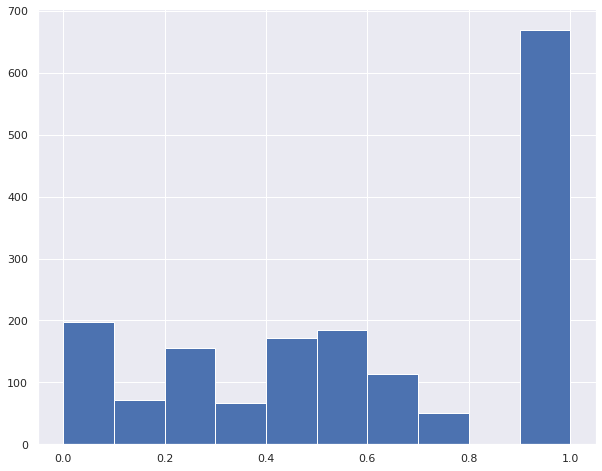

In [ ]:
# Distances distribution
pd.Series(dist.flatten()).hist()

In [ ]:
# get the final weight
1-dist

array([[1.        , 0.70710678, 0.40824829, ..., 0.57735027, 0.91287093,
        0.        ],
       [0.70710678, 1.        , 0.57735027, ..., 0.81649658, 0.77459667,
        0.        ],
       [0.40824829, 0.57735027, 1.        , ..., 0.70710678, 0.4472136 ,
        0.        ],
       ...,
       [0.57735027, 0.81649658, 0.70710678, ..., 1.        , 0.63245553,
        0.        ],
       [0.91287093, 0.77459667, 0.4472136 , ..., 0.63245553, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

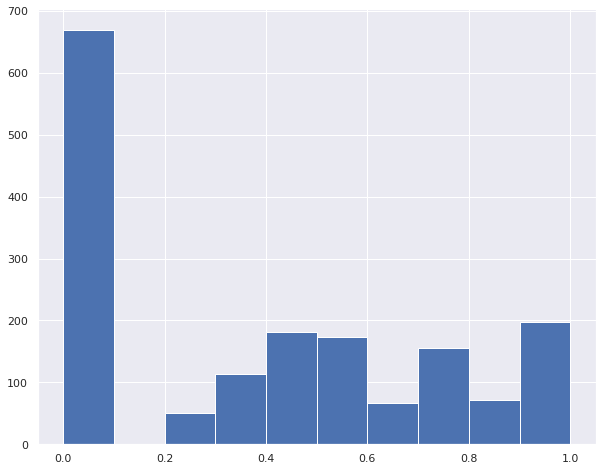

In [ ]:
# Similarity distribution
pd.Series(1-dist.flatten()).hist()

In [ ]:
# calculate a cutoff (for a less crowded network)
perc = np.percentile(1-dist, 60)

perc

0.4999999999999999

In [ ]:
# create NW
G = nx.from_numpy_array(1-dist)

In [ ]:
# Have a first look at the Network
print(G.edges)
print(G.nodes[0])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 32), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 32), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 14), (2, 18), (2, 19), (2, 20), (2, 21), (2, 23), (2, 24), (2, 28), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 14), (3, 18), (3, 19), (3, 20), (3, 21), (3, 23), (3, 24), (3, 28), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39)

In [ ]:
# add names
attributes_dict=df.iloc[:,[0,1,2]].T.to_dict()

attributes_dict

{0: {'Brand': 'Cartier', 'Brand Owner': 'Richemont SA', 'Twitter': 'Cartier'},
 1: {'Brand': 'Van Cleef & Arpels',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'vancleefarpels'},
 2: {'Brand': 'Burberry',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'Burberry'},
 3: {'Brand': 'Baume & Mercier',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'baumeetmercier'},
 4: {'Brand': 'IWC', 'Brand Owner': 'Richemont SA', 'Twitter': 'IWC'},
 5: {'Brand': 'Jaeger-LeCoultre',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'jaegerlecoultre'},
 6: {'Brand': 'Piaget', 'Brand Owner': 'Richemont SA', 'Twitter': 'Piaget'},
 7: {'Brand': 'Ralph Lauren (JV with RL US)',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'RalphLauren'},
 8: {'Brand': 'Roger Dubuis',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'Roger_Dubuis'},
 9: {'Brand': 'Vacheron Constantin',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'Vacheron1755'},
 10: {'Brand': 'Montblanc',
  'Brand Owner': 'Richemont SA',
  'Twitter': 'montblanc_wor

In [ ]:
# Set nodes attributes

nx.set_node_attributes(G, attributes_dict)

In [ ]:
# Check node 31

print(G.nodes[31]["Brand"])
print(G.nodes[31]["Brand Owner"])

Nicholas Kirkwood
LVMH


In [ ]:
# Check edges
G.edges(data=True)

EdgeDataView([(0, 0, {'weight': 1.0}), (0, 1, {'weight': 0.7071067811865477}), (0, 2, {'weight': 0.40824829046386313}), (0, 3, {'weight': 0.40824829046386313}), (0, 4, {'weight': 0.40824829046386313}), (0, 5, {'weight': 0.40824829046386313}), (0, 6, {'weight': 0.5773502691896258}), (0, 7, {'weight': 0.5773502691896258}), (0, 8, {'weight': 0.40824829046386313}), (0, 9, {'weight': 0.40824829046386313}), (0, 10, {'weight': 0.7071067811865477}), (0, 11, {'weight': 0.8333333333333336}), (0, 12, {'weight': 0.6666666666666669}), (0, 13, {'weight': 0.40824829046386313}), (0, 14, {'weight': 0.8660254037844387}), (0, 15, {'weight': 0.40824829046386313}), (0, 16, {'weight': 0.5477225575051662}), (0, 17, {'weight': 0.5477225575051662}), (0, 18, {'weight': 0.40824829046386313}), (0, 19, {'weight': 0.7071067811865477}), (0, 20, {'weight': 0.40824829046386313}), (0, 21, {'weight': 0.40824829046386313}), (0, 22, {'weight': 0.28867513459481287}), (0, 23, {'weight': 0.7715167498104596}), (0, 24, {'weigh

In [ ]:
print(nx.info(G))

Graph with 41 nodes and 526 edges


In [ ]:
# Get rid of low-weight edges
G_sub = nx.edge_subgraph(G, [(u,v) for u,v,d in G.edges(data=True) if d['weight'] > perc])

In [ ]:
print(nx.info(G_sub))

Graph with 40 nodes and 353 edges


In [ ]:
# Set centrality degree
centrality_dgr = nx.degree_centrality(G_sub)
centrality_dgr = pd.DataFrame({'centrality_dgr':centrality_dgr})
centrality_dgr = centrality_dgr.to_dict('index')
nx.set_node_attributes(G_sub, centrality_dgr)

In [ ]:
G_sub.nodes[0]['centrality_dgr']

0.5384615384615384

Now that we have our Network, **let's plot it!**

## **Plot and Analyze the Social Network**

In [ ]:
# identify communities with community_louvain
partition = community_louvain.best_partition(G_sub)
nx.set_node_attributes(G_sub, partition, 'partition')

In [ ]:
position = nx.spring_layout(G_sub)
graph = hv.Graph.from_networkx(G_sub, position).opts(
                                                                        tools=['hover'],
                                                                        edge_alpha=0.15,
                                                                        node_size=13,
                                                                        node_color='partition', cmap='Set1',
                                                                        legend_position='right'
                                                                        )

labels = hv.Labels(graph.nodes, ['x', 'y'])

show(hv.render((graph * labels.opts(text_font_size='0pt', text_color='black', xoffset=-0.01, 
                                    yoffset=-0.04, bgcolor='white', padding=0.2))))

In [ ]:
# Let's use bundle_graph for a better visual

from holoviews.operation.datashader import datashade, bundle_graph
bundled = bundle_graph(graph)
show(hv.render(bundled))

In [ ]:
# Network structure metrics
print(nx.density(G_sub))
print(nx.transitivity(G_sub))

0.45256410256410257
0.7929108071662493


## **Output Dataset with Partition and Centrality**

In [ ]:
# Get Partition and Centrality values
partition_values = [partition.get(node) for node in G_sub.nodes]

centrality_dgr = nx.degree_centrality(G_sub)
centrality_values = [centrality_dgr.get(node) for node in G_sub.nodes]

In [ ]:
# Put Partition and Centrality values into the DataFrame
df['Partition'] = partition_values
df['Centrality'] = centrality_values

# Inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               40 non-null     object 
 1   Brand Owner         40 non-null     object 
 2   Twitter             40 non-null     object 
 3   Apparel             40 non-null     float64
 4   Shoes               40 non-null     float64
 5   Watch               40 non-null     float64
 6   Jewelry             40 non-null     float64
 7   Leather             40 non-null     float64
 8   Accessories/Others  40 non-null     float64
 9   Eyewear             40 non-null     float64
 10  Fragrances          40 non-null     float64
 11  Beauty              40 non-null     float64
 12  Partition           40 non-null     int64  
 13  Centrality          40 non-null     float64
dtypes: float64(10), int64(1), object(3)
memory usage: 4.7+ KB


In [ ]:
# We have a na value, which one?
df[df['Partition'].isnull() == True]

,Brand,Brand Owner,Twitter,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Partition
40,Belmond,LVMH,RIMOWA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
# Drop the na value
df.dropna(inplace=True)

In [ ]:
# Check 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               40 non-null     object 
 1   Brand Owner         40 non-null     object 
 2   Twitter             40 non-null     object 
 3   Apparel             40 non-null     float64
 4   Shoes               40 non-null     float64
 5   Watch               40 non-null     float64
 6   Jewelry             40 non-null     float64
 7   Leather             40 non-null     float64
 8   Accessories/Others  40 non-null     float64
 9   Eyewear             40 non-null     float64
 10  Fragrances          40 non-null     float64
 11  Beauty              40 non-null     float64
 12  Partition           40 non-null     int64  
 13  Centrality          40 non-null     float64
dtypes: float64(10), int64(1), object(3)
memory usage: 4.7+ KB


In [ ]:
# Last Version of the DataFrame before the second version of the Network
df

,Brand,Brand Owner,Twitter,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Partition,Centrality
0,Cartier,Richemont SA,Cartier,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.538462
1,Van Cleef & Arpels,Richemont SA,vancleefarpels,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.615385
2,Burberry,Richemont SA,Burberry,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179
3,Baume & Mercier,Richemont SA,baumeetmercier,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179
4,IWC,Richemont SA,IWC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179
5,Jaeger-LeCoultre,Richemont SA,jaegerlecoultre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179
6,Piaget,Richemont SA,Piaget,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.589744
7,Ralph Lauren (JV with RL US),Richemont SA,RalphLauren,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.589744
8,Roger Dubuis,Richemont SA,Roger_Dubuis,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179
9,Vacheron Constantin,Richemont SA,Vacheron1755,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.487179


In [ ]:
# Partition mean values
df.groupby('Partition').mean()

,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty
Partition,,,,,,,,,
0,0.777778,0.611111,0.444444,0.388889,0.944444,0.888889,0.388889,0.611111,0.166667
1,0.000000,0.000000,0.944444,0.333333,0.000000,0.000000,0.000000,0.111111,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,1.000000


In [ ]:
# Top 10 Centralities
df.sort_values('Centrality', ascending=False).head(10)

,Brand,Brand Owner,Twitter,Apparel,Shoes,Watch,Jewelry,Leather,Accessories/Others,Eyewear,Fragrances,Beauty,Partition,Centrality
10,Montblanc,Richemont SA,montblanc_world,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.666667
1,Van Cleef & Arpels,Richemont SA,vancleefarpels,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.615385
19,Boucheron,Kering,Boucheron,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.615385
38,Chaumet,LVMH,Chaumet,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.589744
6,Piaget,Richemont SA,Piaget,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.589744
7,Ralph Lauren (JV with RL US),Richemont SA,RalphLauren,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.589744
23,Louis Vuitton,LVMH,LouisVuitton,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,0.564103
0,Cartier,Richemont SA,Cartier,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.538462
24,Dior,LVMH,Dior,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.538462
39,Bulgari,LVMH,Bulgariofficial,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0.538462


In [ ]:
# Export the Dataset
df.to_csv('Market Similarities.csv')